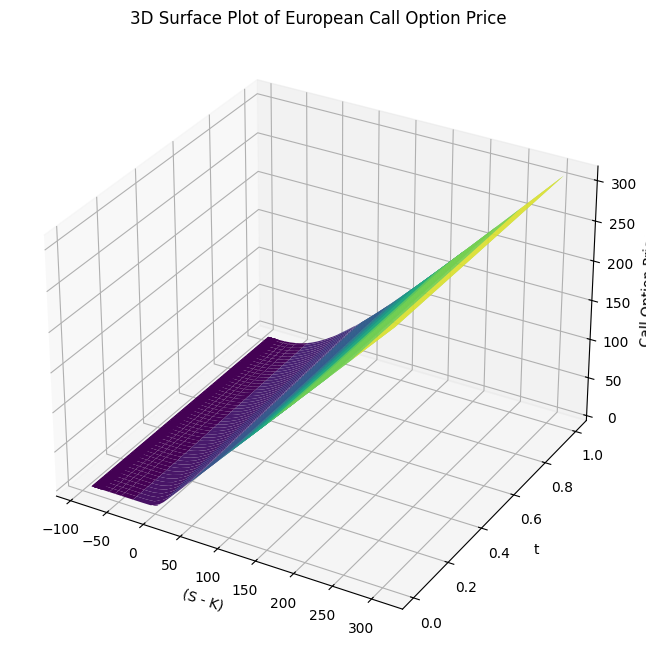

[[7.36305955e-245 5.90357219e-248 8.78532665e-241 ... 8.70606903e+001
  8.43306953e+001 8.06106933e+001]
 [8.60798117e-233 9.84280086e-236 6.43591771e-229 ... 8.70612157e+001
  8.43312207e+001 8.06112187e+001]
 [7.18823865e-222 1.13328710e-224 3.52083525e-218 ... 8.70617410e+001
  8.43317460e+001 8.06117440e+001]
 ...
 [2.52545146e-003 2.31350834e-003 2.83509530e-003 ... 9.35549756e+001
  9.10603390e+001 8.76788848e+001]
 [2.53456179e-003 2.32194274e-003 2.84517957e-003 ... 9.35598505e+001
  9.10652978e+001 8.76839578e+001]
 [2.54369617e-003 2.33039972e-003 2.85528995e-003 ... 9.35647255e+001
  9.10702566e+001 8.76890307e+001]]


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the dataset
df = pd.read_csv('Tesla.csv')

# Parameters for Black-Scholes
K = df['Close'].mean()  # strike price
r = 0.01  # Risk-free rate
sigma = df['Close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
T = np.linspace(0.01, 1, len(df))  # Time to maturity from near zero to 1 year
S = df['Close'].values  # Using actual close prices


# Create a grid for stock prices and time
S_grid, t_grid = np.meshgrid(S, T)

# Calculate d1 and d2 using the Black-Scholes equation
d1 = (np.log(S_grid / K) + (r + 0.5 * sigma**2) * t_grid) / (sigma * np.sqrt(t_grid))
d2 = d1 - sigma * np.sqrt(t_grid)

# Calculate the call and put option prices
call = S_grid * norm.cdf(d1) - K * np.exp(-r * t_grid) * norm.cdf(d2)
put = K * np.exp(-r * t_grid) * norm.cdf(-d2) - S_grid * norm.cdf(-d1)

# Plot the 3D surface for call options
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(S_grid - K, t_grid, call, cmap='viridis')

# Labels and title
ax.set_xlabel('(S - K)')
ax.set_ylabel('t')
ax.set_zlabel('Call Option Price')
ax.set_title('3D Surface Plot of European Call Option Price')
plt.show()

# print call option prices
print(call)




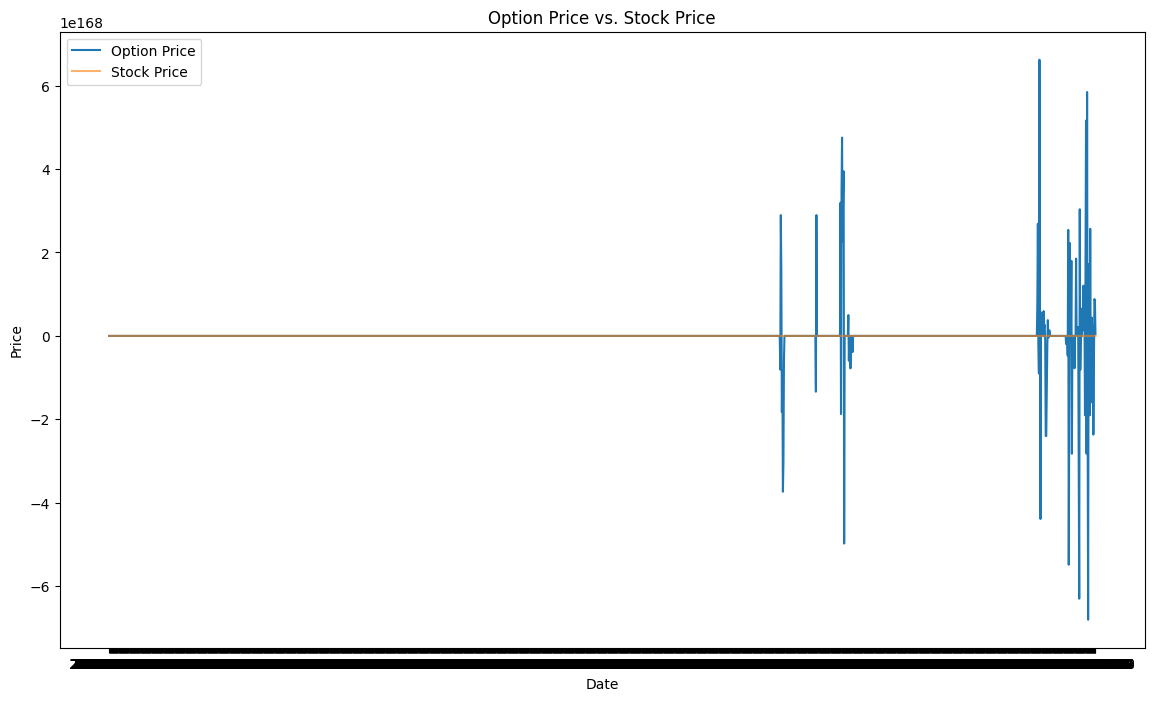

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the dataset
df = pd.read_csv('Tesla.csv')

# Parameters for Black-Scholes
K = df['Close'].mean()  # Strike price
r = 0.01  # Risk-free rate
sigma = df['Close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
T = 1.0  # Time to maturity (1 year)
S_min, S_max = 0, 2 * K  # Minimum and maximum stock prices

# Discretize the stock prices and time
M = 100  # Number of stock price steps
N = 100  # Number of time steps

S = np.linspace(S_min, S_max, M+1)  # Stock price grid
t = np.linspace(0, T, N+1)  # Time grid

# Initialize the option value grid (V)
V = np.zeros((M+1, N+1))

# Set the terminal condition (payoff at maturity)
V[:, -1] = np.maximum(S - K, 0)  # For a call option

# Finite difference coefficients
dS = S[1] - S[0]
dt = t[1] - t[0]

alpha = 0.5 * dt * (sigma**2 * (S / dS)**2 - r * S / dS)
beta = -dt * (sigma**2 * (S / dS)**2 + r)
gamma = 0.5 * dt * (sigma**2 * (S / dS)**2 + r * S / dS)

# Backward time-stepping
for j in range(N-1, -1, -1):
    for i in range(1, M):
        V[i, j] = alpha[i] * V[i-1, j+1] + (1 + beta[i]) * V[i, j+1] + gamma[i] * V[i+1, j+1]
    
    # Apply boundary conditions
    V[0, j] = 0  # As S -> 0, call option price -> 0
    V[-1, j] = S[-1] - K * np.exp(-r * (T - t[j]))  # As S -> S_max, option price approximates intrinsic value

# Interpolate the option prices for the original stock prices in the dataset
option_prices = np.interp(df['Close'], S, V[:, 0])

# Add the option prices to the dataframe
df['Option Price'] = option_prices

# Plot the results
plt.figure(figsize=(14, 8))  # Increase the figure size to make more space
# plot the option price and stock price
plt.plot(df['Date'], df['Option Price'], label='Option Price')
plt.plot(df['Date'], df['Close'], label='Stock Price', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Option Price vs. Stock Price')
plt.legend()
plt.show()

